# V5: 俳句モデル - 条件付き確率分布

日本語文字間の条件付き確率関係を可視化し、俳句モデルが学習した統計的構造を理解します。

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx
from model_analyzer import ModelAnalyzer, InferenceEngine
from tqdm import tqdm

# Seabornのスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

import japanize_matplotlib  # 日本語表示を有効化


## ModelAnalyzerとInferenceEngineの初期化

In [2]:
# 俳句モデルの読み込み
analyzer = ModelAnalyzer('../haiku_orgparam_model.json')
engine = InferenceEngine(analyzer)

モデル読み込み完了: vocab_size=2345, n_layer=1, n_embd=16, block_size=16, n_head=4


## セクション1：条件付き確率行列の計算

In [3]:
# 全トークンに対して条件付き確率を計算
print("条件付き確率行列を計算中...")
print(f"語彙サイズ: {analyzer.vocab_size}")
print("注: 語彙サイズが大きい場合、計算に時間がかかります")

# P(next_token | current_token)の行列を構築
prob_matrix = np.zeros((analyzer.vocab_size, analyzer.vocab_size))

for current_token_id in tqdm(range(analyzer.vocab_size)):
    # 現在トークンをコンテキストとして次トークン確率を計算
    context = [analyzer.BOS, current_token_id]
    probs = engine.get_token_probabilities(context)
    prob_matrix[current_token_id] = probs

print("\n計算完了！")

条件付き確率行列を計算中...
語彙サイズ: 2345
注: 語彙サイズが大きい場合、計算に時間がかかります


100%|██████████| 2345/2345 [00:18<00:00, 126.23it/s]


計算完了！


## セクション2：条件付き確率行列のヒートマップ

注: 日本語の語彙サイズは通常数百文字と大きいため、全体のヒートマップは見づらくなります。
ここではサンプル文字に絞って可視化します。

語彙サイズが大きい（2345文字）ため、サンプル文字のみ表示します


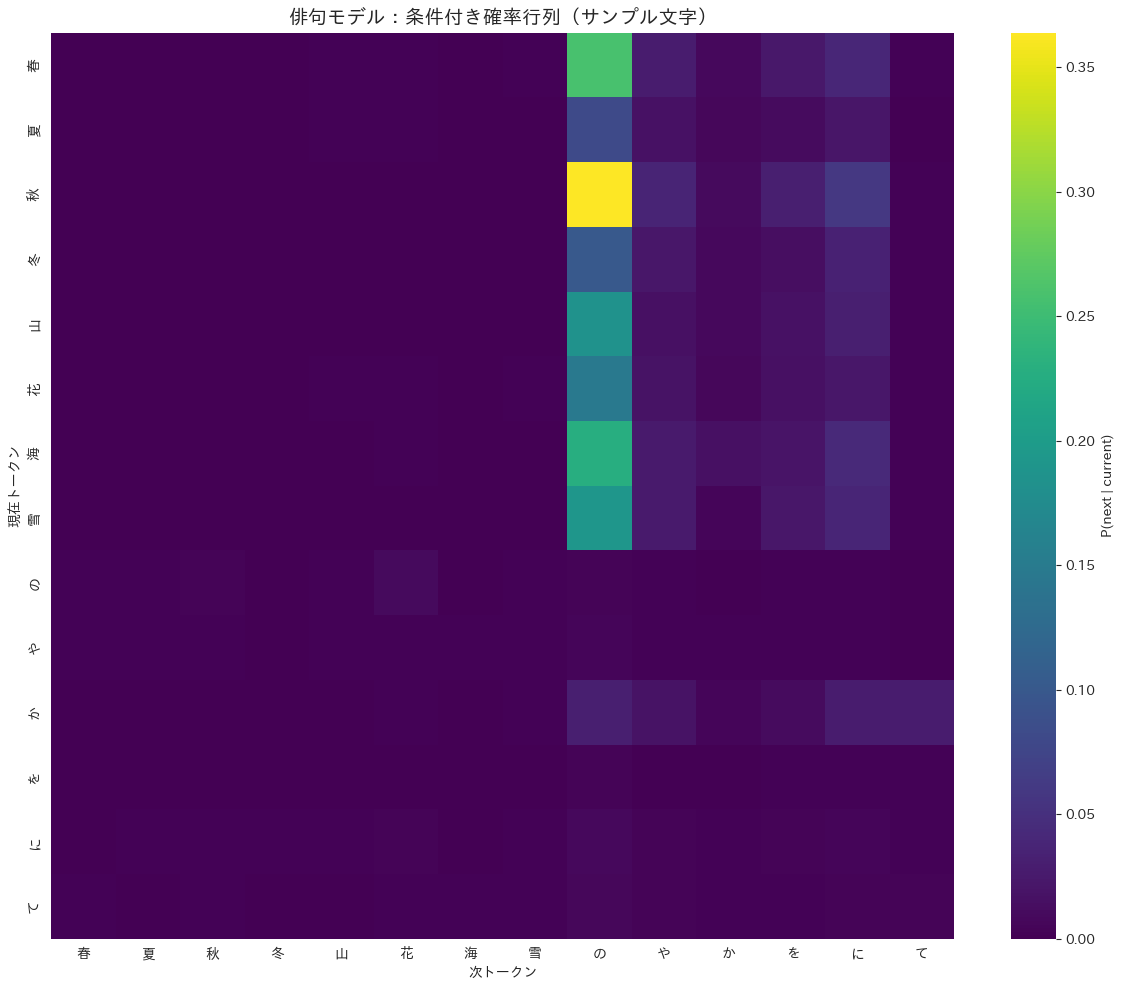

In [4]:
# トークンラベルを作成
token_labels = analyzer.uchars + ['<BOS>']

# 語彙サイズが大きい場合はサンプルに絞る
if analyzer.vocab_size > 100:
    print(f"語彙サイズが大きい（{analyzer.vocab_size}文字）ため、サンプル文字のみ表示します")
    
    # よく使われる俳句の文字をサンプル
    sample_chars = ['春', '夏', '秋', '冬', '山', '花', '海', '雪', '月', 'の', 'や', 'か', 'を', 'に', 'て', '\n']
    sample_indices = []
    sample_labels = []
    
    for ch in sample_chars:
        if ch in analyzer.uchars:
            idx = analyzer.uchars.index(ch)
            sample_indices.append(idx)
            sample_labels.append(ch)
    
    if sample_indices:
        # サンプル文字の確率行列を抽出
        sample_prob_matrix = prob_matrix[np.ix_(sample_indices, sample_indices)]
        
        # ヒートマップで可視化
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            sample_prob_matrix,
            xticklabels=sample_labels,
            yticklabels=sample_labels,
            cmap='viridis',
            cbar_kws={'label': 'P(next | current)'},
            vmin=0,
            vmax=sample_prob_matrix.max(),
            annot=False
        )
        plt.title('俳句モデル：条件付き確率行列（サンプル文字）', fontsize=14)
        plt.xlabel('次トークン')
        plt.ylabel('現在トークン')
        plt.tight_layout()
        plt.show()
    else:
        print("サンプル文字がモデルの語彙に含まれていません")
else:
    # 語彙サイズが小さい場合は全体を表示
    plt.figure(figsize=(16, 14))
    sns.heatmap(
        prob_matrix,
        xticklabels=token_labels,
        yticklabels=token_labels,
        cmap='viridis',
        cbar_kws={'label': 'P(next | current)'},
        vmin=0,
        vmax=prob_matrix.max()
    )
    plt.title('俳句モデル：条件付き確率行列', fontsize=14)
    plt.xlabel('次トークン')
    plt.ylabel('現在トークン')
    plt.tight_layout()
    plt.show()

## セクション3：トークン遷移グラフ

注: 語彙サイズが大きい場合、グラフ描画は複雑になるため、高確率な遷移のみを表示します。

In [5]:
# 確率閾値以上の遷移のみを表示
threshold = 0.1
print(f"閾値: {threshold}（これ以上の確率を持つ遷移のみ表示）")

# 有向グラフを作成
G = nx.DiGraph()

# ノードを追加
for token_id, label in enumerate(token_labels):
    G.add_node(token_id, label=label)

# エッジを追加（確率が閾値以上のもの）
for i in range(analyzer.vocab_size):
    for j in range(analyzer.vocab_size):
        prob = prob_matrix[i, j]
        if prob >= threshold:
            G.add_edge(i, j, weight=prob)

print(f"\nノード数: {G.number_of_nodes()}")
print(f"エッジ数: {G.number_of_edges()}")

# グラフのサイズをチェック
if G.number_of_nodes() > 50:
    print(f"注: ノード数が多いため（{G.number_of_nodes()}）、グラフは複雑になります")
    print("より高い閾値を設定することを推奨します（例: 0.2以上）")

# グラフを描画
if G.number_of_nodes() <= 50:
    plt.figure(figsize=(16, 16))
    pos = nx.circular_layout(G)  # 円周レイアウト
    
    # ノードラベルを作成
    node_labels = {i: token_labels[i] for i in G.nodes()}
    
    # エッジの重みに基づいて太さを設定
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(weights) if weights else 1
    edge_widths = [w / max_weight * 3 for w in weights]  # 最大3ポイント
    
    # グラフを描画
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_labels(G, pos, node_labels, font_size=9)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.3, 
                           edge_color='gray', arrows=True, arrowsize=10,
                           connectionstyle='arc3,rad=0.1')
    
    plt.title(f'俳句モデル：トークン遷移グラフ（確率 >= {threshold}）', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("グラフが大きすぎるため、描画をスキップします")
    print(f"閾値を {threshold * 2:.1f} 以上に上げることを推奨します")

閾値: 0.1（これ以上の確率を持つ遷移のみ表示）

ノード数: 2345
エッジ数: 1205
注: ノード数が多いため（2345）、グラフは複雑になります
より高い閾値を設定することを推奨します（例: 0.2以上）
グラフが大きすぎるため、描画をスキップします
閾値を 0.2 以上に上げることを推奨します


## セクション4：高頻度遷移パターン

In [6]:
# 確率が高い遷移のトップ20を表示
top_k = 20
transitions = []

for i in range(analyzer.vocab_size):
    for j in range(analyzer.vocab_size):
        prob = prob_matrix[i, j]
        transitions.append({
            '現在トークン': token_labels[i],
            '次トークン': token_labels[j],
            '確率': prob
        })

# DataFrameを作成してソート
transitions_df = pd.DataFrame(transitions)
transitions_df = transitions_df.sort_values('確率', ascending=False).head(top_k)

# 表示
print(f"\n高頻度遷移パターン（上位{top_k}件）")
print("=" * 50)
styled_df = transitions_df.reset_index(drop=True).style.background_gradient(
    subset=['確率'], 
    cmap='YlOrRd'
).format({'確率': '{:.4f}'})

display(styled_df)

# 解釈コメント
print("\n解釈:")
print("- 表の上位は、学習データ（俳句）で頻繁に出現する文字の組み合わせを反映しています")
print("- 助詞や助動詞、季語の文字遷移パターンが見られます")
print("- モデルは日本語文字レベルのn-gram統計を学習していることがわかります")


高頻度遷移パターン（上位20件）


,現在トークン,次トークン,確率
0,哉,,0.5624
1,紅,葉,0.4657
2,秋,の,0.3639
3,顏,の,0.3360
4,鶯,の,0.3334
5,け,り,0.3198
6,穂,の,0.3184
7,菊,の,0.3150
8,凧,の,0.3108
9,椎,の,0.3043



解釈:
- 表の上位は、学習データ（俳句）で頻繁に出現する文字の組み合わせを反映しています
- 助詞や助動詞、季語の文字遷移パターンが見られます
- モデルは日本語文字レベルのn-gram統計を学習していることがわかります


## セクション5：特定コンテキストの次トークン分布

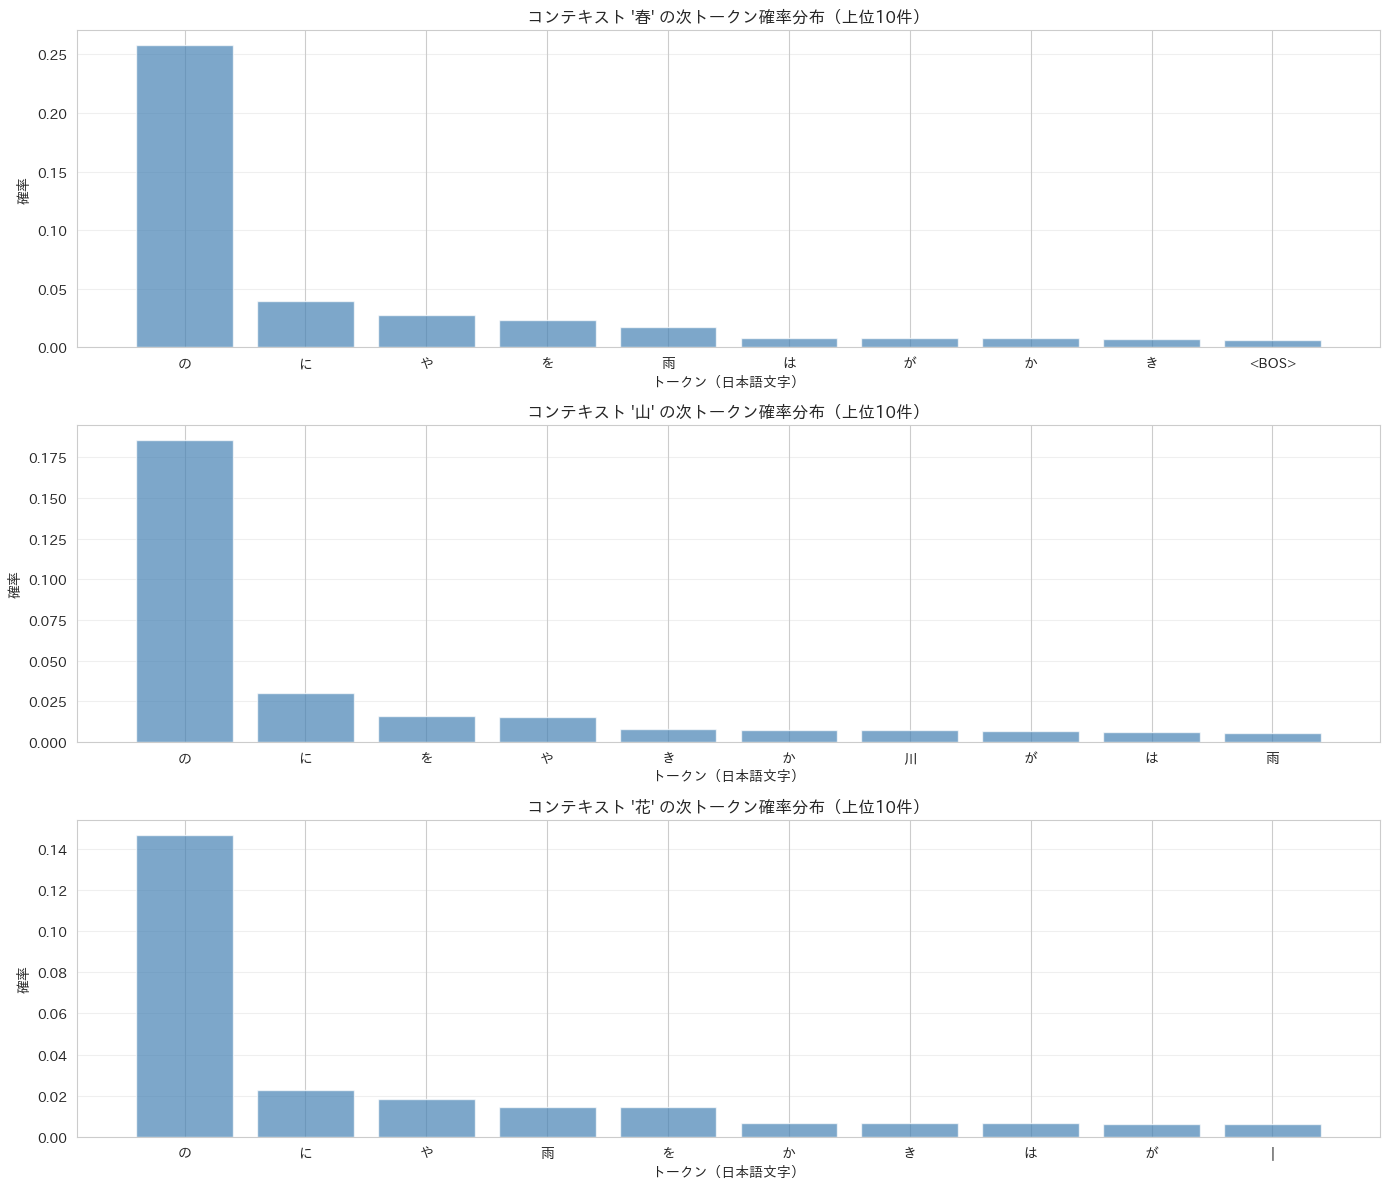

In [7]:
# 特定のコンテキストに対する次トークン確率を比較
# 俳句でよく使われる文字をテスト
test_contexts = ['春', '山', '花']

fig, axes = plt.subplots(len(test_contexts), 1, figsize=(14, 4 * len(test_contexts)))
if len(test_contexts) == 1:
    axes = [axes]

for idx, context_str in enumerate(test_contexts):
    # コンテキストをトークンIDに変換
    context_ids = [analyzer.BOS] + analyzer.tokenize(context_str)
    
    # 次トークン確率を取得
    probs = engine.get_token_probabilities(context_ids)
    
    # 上位10件を取得
    top_k = 10
    top_indices = np.argsort(probs)[-top_k:][::-1]
    
    # データを準備
    top_tokens = [token_labels[i] for i in top_indices]
    top_probs = [probs[i] for i in top_indices]
    
    # 棒グラフで表示
    ax = axes[idx]
    ax.bar(top_tokens, top_probs, color='steelblue', alpha=0.7)
    ax.set_title(f"コンテキスト '{context_str}' の次トークン確率分布（上位{top_k}件）", fontsize=12)
    ax.set_xlabel('トークン（日本語文字）')
    ax.set_ylabel('確率')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## セクション6：Plotlyインタラクティブ棒グラフ

In [8]:
# 複数のコンテキストを比較するインタラクティブグラフ

# 各コンテキストのデータを準備
top_k = 10
data_traces = []

for context_str in test_contexts:
    context_ids = [analyzer.BOS] + analyzer.tokenize(context_str)
    probs = engine.get_token_probabilities(context_ids)
    
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_tokens = [token_labels[i] for i in top_indices]
    top_probs = [probs[i] for i in top_indices]
    
    trace = go.Bar(
        x=top_tokens,
        y=top_probs,
        name=f"'{context_str}'",
        hovertemplate='トークン: %{x}<br>確率: %{y:.4f}<extra></extra>'
    )
    data_traces.append(trace)

# グラフを作成
fig = go.Figure(data=data_traces)

fig.update_layout(
    title='俳句モデル：コンテキスト別次トークン確率分布（インタラクティブ）',
    xaxis_title='次トークン',
    yaxis_title='確率',
    barmode='group',
    width=1000,
    height=600,
    hovermode='x unified'
)

fig.show()

## まとめ

このNotebookでは、日本語俳句モデルの条件付き確率分布を可視化しました:

### 主な発見
1. **条件付き確率行列**: 日本語文字間の遷移確率を分析
2. **遷移グラフ**: 高確率な文字遷移をグラフ構造で可視化
3. **高頻度パターン**: 俳句データの統計的構造（助詞、季語など）を反映した遷移パターン
4. **コンテキスト依存**: 同じ文字でも前のコンテキストにより次の文字の分布が変化

### 観察ポイント
- モデルは日本語文字レベルのn-gram統計をうまく学習している
- 特定の文字の組み合わせ（助詞、助動詞など）で強い遷移傾向が見られる
- コンテキストにより次トークンの確率分布が大きく異なる
- 季語や俳句特有の表現パターンが確率行列に反映されている

### 技術的課題
- 日本語の語彙サイズが大きい（数百文字）ため、全体のヒートマップは複雑
- サンプル文字に絞った可視化が有効
- 高頻度遷移パターンの分析により、効率的に統計的構造を理解できる

これで俳句モデルの全5つのNotebookによる可視化が完了しました！